# Process Dataset

In [2]:
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 400)

import ast
import json
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm import tqdm

tokenizer_emb = AutoTokenizer.from_pretrained("mixedbread-ai/mxbai-embed-large-v1")
tokenizer_lm = AutoTokenizer.from_pretrained("google/gemma-2b-it")

/Users/lucapagano/miniconda3/envs/THESIS/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load Reviews

In [1]:
import os
os.chdir('../../')

In [11]:
sessions = []
items = []
timestamp = [] 
rating = []
text = []

with open("Dataset/amazon-tv/Movies_and_TV.jsonl") as f: 
    for l in f:
        interaction = json.loads(l.strip())
        sessions.append(interaction["user_id"])
        items.append(interaction["parent_asin"])
        timestamp.append(interaction["timestamp"])
        rating.append(interaction["rating"])
        text.append(interaction["text"])

raw_session_df = pd.DataFrame({"SessionId": sessions, "ItemId": items, "Time": timestamp, "Rating": rating, "Text": text})
raw_session_df.head()

,SessionId,ItemId,Time,Rating,Text
0,AGGZ357AO26RQZVRLGU4D4N52DZQ,B013488XFS,1440385637000,5.0,"Amazon, please buy the show! I'm hooked!"
1,AGKASBHYZPGTEPO6LWZPVJWB2BVA,B00CB6VTDS,1461100610000,5.0,My Kiddos LOVE this show!!
2,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,B096Z8Z3R6,1646271834582,3.0,"Annabella Sciorra did her character justice with her portrayal of a mentally ill, depressed and traumatized individual who projects much of her inner wounds onto others. The challenges she faces with her father were sensitively portrayed and resonate with understanding and love. The ending really isn't an ending, though and feels like it was abandoned with not enough of a closure but other tha..."
3,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,B09M14D9FZ,1645937761864,4.0,"...there should be more of a range of characters with high-functioning autism, too. Jack is the closest representation but also falls on the more severe scale, socially. I love that the storyline of some episodes tie in heartwarming, moving moments which depict the struggles often faced by those on the spectrum. This show definitely has a ton of potential and I hope future seasons bring in mor..."
4,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,B001H1SVZC,1590639227074,5.0,"...isn't always how you expect it to be, but when its there, you know. That is what this movie is all about. Deep struggles within a broken home and a mother with an addiction and a best friend whom nobody else seems to understand but him. There's loss, there's triumph. There's a bit of magic with a psychic neighbor who makes quite an impact on the boy. This is one definitely worth your time."


In [13]:
# Save csv to Dataset folder
raw_session_df.to_csv("Dataset/amazon-tv/langptune/amazon_tv_raw.csv", index=False)

In [3]:
raw_session_df = pd.read_csv("Dataset/amazon-tv/langptune/amazon_tv_raw.csv")

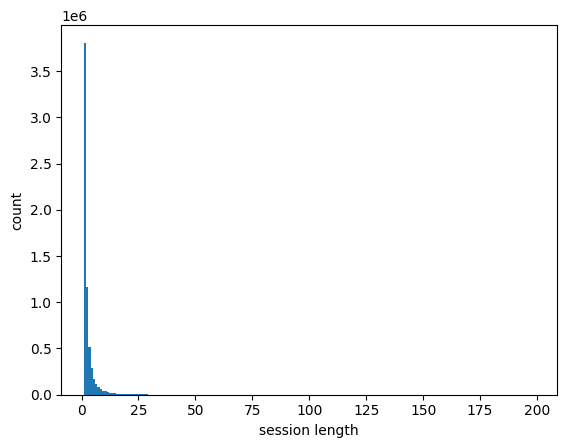

In [5]:
# plt.yscale('log')
plt.xlabel('session length')
plt.ylabel('count')
plt.hist(list(dict(raw_session_df["SessionId"].value_counts()).values()), bins=np.arange(1, 200))
plt.show()

#### Load Metadata

In [6]:
descriptions = []
items = []
categories = []
titles = []
prices = []
details = []
average_rating = []

with open("Dataset/amazon-tv/meta_Movies_and_TV.jsonl") as f:
    for l in f:
        item = json.loads(l.strip())

        if item['title'] == None:
            continue

        titles.append(str(item['title']))

        try:
            descriptions.append(' '.join(item['description']))
        except:
            descriptions.append('None')

        items.append(item['parent_asin'])

        if item['categories'] == None:
            categories.append('None')
        else:
            categories.append(', '.join(item['categories']))

        prices.append(str(item['price']))
        details.append(item['details'])
        average_rating.append(item['average_rating'])

In [7]:
item_des_dict = {}
for i in range(len(items)):
    assert items[i] not in item_des_dict
    item_des_dict[items[i]] = {"Title": titles[i], "Description": descriptions[i], "Category": categories[i], "price": prices[i], "details": details[i], "average_rating": average_rating[i]}

raw_item_des_df = pd.DataFrame({"ItemId": items, "Title": titles, "Description": descriptions, "Category": categories, "price": prices, "details": details, "average_rating": average_rating})
raw_item_des_df.head()

,ItemId,Title,Description,Category,price,details,average_rating
0,B00ABWKL3I,Glee,"Entering its fourth season, this year the members of New Directions compete amongst themselves to be the ""new Rachel"" and hold auditions to find new students. Meanwhile, the graduating class leaves the comforts of McKinley where Rachel struggles to please her demanding NYADA teacher (Kate Hudson) and Kurt second-guesses his decision to stay in Lima. Four newcomers also join the musical comedy.","Comedy, Drama, Arts, Entertainment, and Culture, Music Videos and Concerts",22.39,"{'Content advisory': ['Violence', 'substance use', 'alcohol use', 'smoking', 'foul language', 'sexual content'], 'Audio languages': ['English'], 'Subtitles': ['English [CC]'], 'Directors': ['Bradley Buecker', 'Brad Falchuk', 'Eric Stoltz', 'Paris Barclay', 'Ian Brennan', 'Ryan Murphy', 'Alfonso Gomez-Rejon', 'Elodie Keene', 'Adam Shankman', 'Paul McCrane']}",4.7
1,B09WDLJ4HP,One Perfect Wedding,"With her book tour in two weeks and his expanding business plans, Cara and Ben put their long engagement behind them and book the chalet for a small wedding with friends and family. Starring Taylor Cole and Jack Turner.","Comedy, Drama, Romance",None,"{'Audio languages': ['English'], 'Subtitles': ['English [CC]'], 'Directors': ['Gary Yates'], 'Producers': ['Anthony Fankhauser', 'Graem Luis', 'Melinda Wells McCabe', 'Emily Merlin', 'Stan Spry', 'Eric Scott Woods']}",3.0
2,B00AHN851G,How to Make Animatronic Characters - Organic Mechanics Part 2,"Product Description In PART TWO of this incredible journey through the world of animatronics, the master of The Character Shop, Rick Lazzarini, not only builds upon the lessons he introduced in Part One, but also shares a host of additional mechanical techniques, as he continues with the construction of his lifelike puma. Here, Rick creates expressiveness in his animatronic creature by focusin...","Movies & TV, Genre for Featured Categories, Special Interests",64.99,"{'Package Dimensions': '7.52 x 5.31 x 0.71 inches; 3.84 Ounces', 'Director': 'Stan Winston School of Character Arts', 'Media Format': 'Multiple Formats, Dolby, NTSC, Widescreen', 'Run time': '4 hours and 18 minutes', 'Release date': 'August 19, 2012', 'Actors': 'Rick Lazzarini', 'Studio': 'Stan Winston School of Character Arts', 'Country of Origin': 'USA', 'Number of discs': '2'}",5.0
3,B01G9ILXXE,Ode to Joy: Beethoven's Symphony No. 9,"This special Ode to Joy: Beethoven's Symphony No. 9 showcases this musical masterpiece in a rare television recording by the Vienna Chamber Orchestra with the Westminster Symphonic Choir, under the direction of conductor Mark Laycock.",Documentary,5.99,"{'Audio languages': ['English'], 'Subtitles': ['English [CC]'], 'Directors': ['Karen McLaughlin'], 'Producers': ['Eric Schultz', 'Susan Wallner']}",4.3
4,B009SIYXDA,Ben 10: Alien Force (Classic),"Itâ€™s hero time again for Ben as he saves the Earth from Vilgaxâ€™s power. This season, Ben, Gwen and Kevin go head-to-head with repo men, bounty hunters and a charming long, lost villain. Ben winds up lending a hand to a popcorn-munching alien and Julie (literally!). If Ben can keep the Omnitrix under control, he might stand a chance at saving Grandpa Max once and for all.","Science Fiction, Comedy, Animation, Drama",24.49,"{'Audio languages': ['English'], 'Subtitles': ['English [CC]'], 'Directors': ['Dan Riba', 'Butch Lukic', 'John Fang', 'Rick Morales'], 'Producers': ['Dwayne McDuffie', 'Donna Smith', 'Glen Murakami', 'Brian A. Miller', 'Jennifer Pelphrey', 'Sam Register']}",4.7


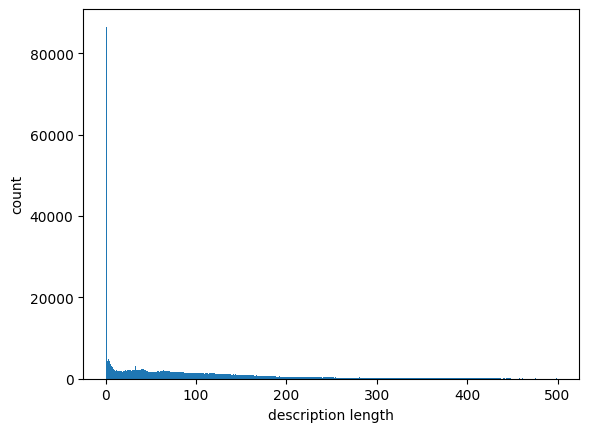

In [8]:
word_counts = []
for index, row in raw_item_des_df.iterrows():
    d = row['Description']
    word_counts.append(len(d.split()))

plt.clf()
# plt.yscale('log')
plt.xlabel('description length')
plt.ylabel('count')
plt.hist(word_counts, bins=np.arange(0, 500))
plt.show()

# Process Reviews

In [9]:
# filter reviews with items that are not in the meta description file
drop_idx = []
for i in range(len(raw_session_df["ItemId"])):
    if raw_session_df["ItemId"][i] not in item_des_dict:
        drop_idx.append(i)

print("Drop ratio: ", len(drop_idx)/len(raw_session_df))
print("Length before drop: ", len(raw_session_df))
raw_session_df = raw_session_df.drop(drop_idx).reset_index(drop=True)
print("Length after drop: ", len(raw_session_df))
print(raw_session_df.head())

Drop ratio:  0.543655834029785
Length before drop:  17328314
Length after drop:  7907675
                      SessionId      ItemId           Time  Rating  \
0  AGGZ357AO26RQZVRLGU4D4N52DZQ  B013488XFS  1440385637000     5.0   
1  AGKASBHYZPGTEPO6LWZPVJWB2BVA  B00CB6VTDS  1461100610000     5.0   
2  AGCI7FAH4GL5FI65HYLKWTMFZ2CQ  B01BZ4DOGQ  1493616276000     5.0   
3  AGXVBIUFLFGMVLATYXHJYL4A5Q7Q  B0002J58ME  1146713492000     5.0   
4  AHITBJSS7KYUBVZPX7M2WJCOIVKQ  B079FLYB41  1560014052867     5.0   

                                                                                                                                                                                                                                                                                                                                                                                                              Text  
0                                                                                    

In [10]:
# filter items/users with a few interactions
MIN_NUM_INTERACTIONS = 5

processed_session_df = raw_session_df.copy()
prev_len_processed_session_df = len(processed_session_df)
while True: 
    print("Iteration ")

    # Compute sessions to keep.
    sessions_to_keep = {session for session, value_count in processed_session_df["SessionId"].value_counts().items() if value_count >= MIN_NUM_INTERACTIONS}
    processed_session_df = processed_session_df[processed_session_df["SessionId"].isin(sessions_to_keep)]
    
    # Compute items to keep.
    items_to_keep = {item for item, value_count in processed_session_df["ItemId"].value_counts().items() if value_count >= MIN_NUM_INTERACTIONS}
    processed_session_df = processed_session_df[processed_session_df["ItemId"].isin(items_to_keep)]
    
    if prev_len_processed_session_df == len(processed_session_df):
        break

    prev_len_processed_session_df = len(processed_session_df)

print(f"Number of sessions: {len(sessions_to_keep)}")
print(f"Number of items: {len(items_to_keep)}")

processed_session_df.sort_values(by="Time", inplace=True)
processed_session_df.head(10)

Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Number of sessions: 238405
Number of items: 106391


,SessionId,ItemId,Time,Rating,Text
3321942,AGNELUVI3HO2U62UADN6ZDEEQWIA,6300181553,883582160000,5.0,"This is one of the finest holiday films ever made.<br />Inspired by a story by Irving Berlin, the film features many wonderful Berlin holiday tunes, from &quot;White Christmas&quot; to &quot;Easter Parade&quot;. This is the film that introduced &quot;White Christmas&quot;, Bing Crosby's signature song (which was almost cut from the final version!).<br />Holiday hijinks ensue when Jim Hardy (Bi..."
3219182,AGGIKKF5GCB5MZLCUJ364EMPFNTQ,6302098475,883861394000,4.0,"This verison (which was first made as a theatrical film for European cinema, then shown on FOX TV, and then shortened for video by about forty minutes) stars Patrick Bergin as the outlawed Earl of Huntington (portrayed with some touches of humor and plenty of physical action and presence); Uma Thurman as a very independent Lady Marian; Jeroen Krabbe as the Norman lord who was once Robin's frie..."
6870182,AEYKLLDB3WOTU25O2PMRFVE6I3IA,0800184319,890780757000,5.0,"After I saw this movie it instantly became one of my all time favorites. After reading the novel by Lois Duncan I felt that it may have deviated from the original story a bit too much. Nevertheless, Jennifer Love Hewitt gave an incredible performance. I do feel though that too many characters got killed in it. Should have kept some for the sequal. END"
6674907,AHIESZVUWCPHZC7QEANXAI5OCGBA,6302484502,891105363000,4.0,"Any film directed by Orson Welles is engrossing and worth the time. MACBETH is no exception. For those of you familiar with the 1971 Roman Polanski version, Welles brought to the screen a darker, more nightmarish world than Polanski could envision. The lighting is stark and the shadows ominous. Macbeth's madness increasingly pervades the atmosphere of the entire film, making the viewer un..."
2914409,AF4OM67Q62MWNQEL7TPEYBRLSUUA,6303567126,891124916000,5.0,"If Leonardo diCaprio had not already made this film, he would be cast immediately for the role of lifetime. Mr. diCaprio's performance as the lanky, audacious, and attitude-heavy high school basketball player whose descent into heroin-hell is the true story of the author, Jim Carroll, can only be described as superb. As often as diCaprio is cited for his Titanic performance, &quot;Basketball D..."
7452255,AFMCLVQVJZKGFGIZHPZDP53SLPSA,6301963636,891637238000,4.0,"In certain scenes, you can see the weariness in Errol Flynn's face. At times, the years of drinking and brawling and general misbehavior are shockingly apparent. Yet despite that, Flynn's portrayal of a jaded, world-weary -- but ultimately humorous and carefree -- Don Juan is a delight to watch. It was the last great swashbuckling film he would make, and the last in which any great care was ta..."
7452252,AFMCLVQVJZKGFGIZHPZDP53SLPSA,6302120527,891718786000,5.0,"In his autobiography, Jack L. Warner said Errol Flynn's sudden rise to stardom was like a &quot;wildfire&quot; sweeping across the landscape. In &quot;Captain Blood,&quot; a 26-year-old Errol Flynn burst on the scene with drop-dead good looks, a knack for generating excitement, and one of the most powerful screen personas of any star in the history of film. This story of a doctor-turned-pirate..."
7452251,AFMCLVQVJZKGFGIZHPZDP53SLPSA,6302682622,891887185000,5.0,"In real life, Errol Flynn was no pushover. Despite devastating good looks and a wickedly easygoing charm, he could hold his own in either a one-on-one fightfight or a barroom brawl. He was, in fact, one of the most feared fighters in Hollywood.<br />&quot;Gentleman Jim,&quot; the story of 19th century boxer James J. Corbett, gave Warner Brothers a chance to put their bad boy on display at his ..."
7452250,AFMCLVQVJZKGFGIZHPZDP53SLPSA,6302120616,892748741000,5.0,"&quot;The Charge of the Light Brigade,&quot; which was released in 1936, was Errol Flynn's second starring role. Already an international sensation thanks to &quot;Captain Blood,&quot; Flynn shot to even higher lev

In [11]:
session_dict = {}
for index, row in processed_session_df.iterrows():
    if row["SessionId"] in session_dict:
        session_dict[row["SessionId"]].append((row["ItemId"], row['Rating'], row['Text']))
    else:
        session_dict[row["SessionId"]] = [(row["ItemId"], row['Rating'], row['Text'])]

In [12]:
MAX_LM_LEN = 1024
MAX_RM_LEN = 512
PROMPT = "The user has rated (out of 5.0) and reviewed following movies and TV shows arranged chronologically from the oldest (top) to the newest (bottom). Please provide a high-level summary of the user preference in detail."

# remove items with long descriptions
item_to_remove = {}
for k, item in tqdm(item_des_dict.items()):
    current_item = f'Title: {item["Title"]}\nDescription: (average rating: {item["average_rating"]}) {item["Description"]}\nCategory: {item["Category"]}\nPrice: {item["price"]}'
    if len(tokenizer_emb(current_item)['input_ids']) > MAX_RM_LEN:
        item_to_remove[k] = 1

print(len(item_des_dict))
print(len(item_to_remove))

100%|██████████| 434236/434236 [02:15<00:00, 3215.76it/s]

434236
16893


In [13]:
# remove sessions with long prompts
sess_to_remove = {}
for k in tqdm(session_dict.keys()):

    for i in session_dict[k]:
        if i[0] in item_to_remove:
            sess_to_remove[k] = 1
            break
    
    if k in sess_to_remove:
        continue

    prompt = [PROMPT]
    for i in session_dict[k][:4]:
        item = item_des_dict[i[0]]
        current_item = f'Title: {item["Title"]}\nDescription: (average rating: {item["average_rating"]}) {item["Description"]}\nCategory: {item["Category"]}\nPrice: {item["price"]}'
        prompt.append(current_item + f'\nReview from the user: (rating: {i[1]}) {i[2]}')
    prompt = "\n\n".join(prompt)
    prompt = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model"
    if len(tokenizer_lm(prompt)['input_ids']) > MAX_LM_LEN:
        sess_to_remove[k] = 1

print("Total number of sessions: ", len(session_dict.keys()))
print("Number of sessions to remove: ", len(sess_to_remove.keys()))

100%|██████████| 238405/238405 [02:53<00:00, 1372.28it/s]

Total number of sessions:  238405
Number of sessions to remove:  191674


In [14]:
processed_session_df = processed_session_df.reset_index(drop=True)
drop_idx = []
for i in range(len(processed_session_df["SessionId"])):
    if processed_session_df["SessionId"][i] in sess_to_remove:
        drop_idx.append(i)

print("Drop ratio: ", len(drop_idx)/len(processed_session_df))
print("Length before drop: ", len(processed_session_df))
processed_session_df = processed_session_df.drop(drop_idx).reset_index(drop=True)
print("Length after drop: ", len(processed_session_df))
print(raw_session_df.head())

Drop ratio:  0.8860962365972863
Length before drop:  3114761
Length after drop:  354783
                      SessionId      ItemId           Time  Rating  \
0  AGGZ357AO26RQZVRLGU4D4N52DZQ  B013488XFS  1440385637000     5.0   
1  AGKASBHYZPGTEPO6LWZPVJWB2BVA  B00CB6VTDS  1461100610000     5.0   
2  AGCI7FAH4GL5FI65HYLKWTMFZ2CQ  B01BZ4DOGQ  1493616276000     5.0   
3  AGXVBIUFLFGMVLATYXHJYL4A5Q7Q  B0002J58ME  1146713492000     5.0   
4  AHITBJSS7KYUBVZPX7M2WJCOIVKQ  B079FLYB41  1560014052867     5.0   

                                                                                                                                                                                                                                                                                                                                                                                                              Text  
0                                                                                     

In [15]:
# filter items/users with a few interactions
MIN_NUM_INTERACTIONS = 5

prev_len_processed_session_df = len(processed_session_df)
while True: 
    print("Iteration ")

    # Compute sessions to keep.
    sessions_to_keep = {session for session, value_count in processed_session_df["SessionId"].value_counts().items() if value_count >= MIN_NUM_INTERACTIONS}
    processed_session_df = processed_session_df[processed_session_df["SessionId"].isin(sessions_to_keep)]
    
    # Compute items to keep.
    items_to_keep = {item for item, value_count in processed_session_df["ItemId"].value_counts().items() if value_count >= MIN_NUM_INTERACTIONS}
    processed_session_df = processed_session_df[processed_session_df["ItemId"].isin(items_to_keep)]
    
    if prev_len_processed_session_df == len(processed_session_df):
        break

    prev_len_processed_session_df = len(processed_session_df)

print(f"Number of sessions: {len(sessions_to_keep)}")
print(f"Number of items: {len(items_to_keep)}")

processed_session_df.sort_values(by="Time", inplace=True)
processed_session_df.head(10)

Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Iteration 
Number of sessions: 19681
Number of items: 10945


,SessionId,ItemId,Time,Rating,Text
27,AGLIO4USU24KCMP6J5RFJCVQNQJA,0792839137,920069848000,1.0,"I have to say this is the biggest letdown I have had in the past 10 years. L. DiCaprio is pathetic. The other actors are sleep walking through the entire thing, probably regretting the fact that they were ever involved and wanting to end their self-induced torture as quickly as possible.<br />If you are brain damaged or a 14 year old acne faced female in love with L. DiCaprio you will enj..."
67,AH66ADZWA2DPHUEB6WWDVIQJQUXA,1563353121,943624858000,5.0,"This is a great movie and it really hit home as we have a 15 year old blind Arabian mare. Even though she is blind she is smart, a great trail horse and mother. She has the courage to prove not all blind horses are worthless. She will never be sold and has found a loving home with us. Though she has been banned from riding competition due to her blindness she is taken on long trail rides, a..."
68,AH66ADZWA2DPHUEB6WWDVIQJQUXA,1563353121,943624858000,5.0,"This is a great movie and it really hit home as we have a 15 year old blind Arabian mare. Even though she is blind she is smart, a great trail horse and mother. She has the courage to prove not all blind horses are worthless. She will never be sold and has found a loving home with us. Though she has been banned from riding competition due to her blindness she is taken on long trail rides, a..."
69,AH66ADZWA2DPHUEB6WWDVIQJQUXA,1563353121,943624858000,5.0,"This is a great movie and it really hit home as we have a 15 year old blind Arabian mare. Even though she is blind she is smart, a great trail horse and mother. She has the courage to prove not all blind horses are worthless. She will never be sold and has found a loving home with us. Though she has been banned from riding competition due to her blindness she is taken on long trail rides, a..."
70,AH66ADZWA2DPHUEB6WWDVIQJQUXA,1563353121,943624858000,5.0,"This is a great movie and it really hit home as we have a 15 year old blind Arabian mare. Even though she is blind she is smart, a great trail horse and mother. She has the courage to prove not all blind horses are worthless. She will never be sold and has found a loving home with us. Though she has been banned from riding competition due to her blindness she is taken on long trail rides, a..."
71,AH66ADZWA2DPHUEB6WWDVIQJQUXA,1563353121,943624858000,5.0,"This is a great movie and it really hit home as we have a 15 year old blind Arabian mare. Even though she is blind she is smart, a great trail horse and mother. She has the courage to prove not all blind horses are worthless. She will never be sold and has found a loving home with us. Though she has been banned from riding competition due to her blindness she is taken on long trail rides, a..."
72,AH66ADZWA2DPHUEB6WWDVIQJQUXA,1563353121,943624858000,5.0,"This is a great movie and it really hit home as we have a 15 year old blind Arabian mare. Even though she is blind she is smart, a great trail horse and mother. She has the courage to prove not all blind horses are worthless. She will never be sold and has found a loving home with us. Though she has been banned from riding competition due to her blindness she is taken on long trail rides, a..."
207,AF3BQFFH622BRDD4EB6L5WGAKFGA,B00003Q43D,959602815000,5.0,"I was interested but figured i'd see another sloppy recreation. Instead I saw dinosaurs - images that will stay with me forever. Better, I saw them in the newer form of nature documentary which combines a story with hard facts. Best of all are the segments where scientist frankly discuss what is known and what is not known. I was riveted and could not stop watching."
208,AF3BQFFH622BRDD4EB6L5WGAKFGA,B00003Q43D,959602815000,5.0,"I was interested but figured i'd see another sloppy recreation. Instead I saw dinosaurs - images that will stay with me forever. Better, I saw them in the newer form of nature documentary which combines a story with hard facts. Best of all are the segments whe

In [16]:
item_ids = set(processed_session_df["ItemId"].unique())
processed_item_df = raw_item_des_df[raw_item_des_df["ItemId"].isin(item_ids)].reset_index(drop=True)
processed_item_df.head(10)

,ItemId,Title,Description,Category,price,details,average_rating
0,B07R6X1PFL,The Curse of La Llorona,A social worker investigating the disappearance of two children discovers her own family might also be in danger.,"Suspense, Horror, Anxious, Emotional",12.99,"{'Audio languages': ['English', 'English [Audio Description]'], 'Subtitles': ['English [CC]'], 'Directors': ['Michael Chaves'], 'Producers': ['Richard Brener', 'Michael Clear', 'Gary Dauberman', 'Emile Gladstone', 'Walter Hamada', 'Michelle Morrissey', 'Dave Neustadter', 'Victoria Palmeri', 'Judson Scott'], 'Starring': ['Linda Cardellini', 'Raymond Cruz', 'Patricia Velasquez']}",4.2
1,B00SB2OYL0,Paddington,"Based on the beloved novels and featuring an all-star cast, PADDINGTON follows a young bear who finds himself in a series of comic misadventures while trying to avoid a museum taxidermist.","Comedy, Kids, Charming, Playful",None,"{'Subtitles': ['None available'], 'Directors': ['Paul King'], 'Producers': ['David Heyman', 'Rosie Alison', 'Jeffrey Clifford', 'Alexandra Ferguson', 'Oliver Courson', 'Ron Halpern', 'Bob Weinstein', 'Harvey Weinstein'], 'Starring': ['Ben Whishaw', 'Nicole Kidman', 'Michael Gambon']}",4.7
2,B00IKM5LXG,"I, Frankenstein [DVD + Digital]","Frankenstein's creature, Adam, has survived into the present day due to a genetic quirk in his creation. Making his way to a dark, gothic metropolis, he finds himself caught in an all-out, centuries old war between two immortal clans.","Movies & TV, Genre for Featured Categories, Action & Adventure",7.99,"{'Genre': 'Action', 'Format': 'Multiple Formats, Closed-captioned, NTSC, Color, Subtitled, Widescreen', 'Contributor': 'Aaron Eckhardt, Stuart Beattie, Bill Nighy, Miranda Otto', 'Language': 'English', 'Runtime': '1 hour and 33 minutes', 'Is Discontinued By Manufacturer': 'No', 'MPAA rating': 'PG-13 (Parents Strongly Cautioned)', 'Product Dimensions': '0.7 x 7.5 x 5.4 inches; 1.6 Ounces', 'Aud...",4.4
3,B005CFC0L0,A Family Thanksgiving,"Claudia ( Daphne Zuniga ) is a workaholic who wants more than anything to make partner at her law firm. To accomplish her goal, she has put everyone and everything else on the backburner. But when a mysterious woman ( Faye Dunaway ) uses a bit of magic to help Claudia realize what she's been missing, she gets a serious dose of reality. Transported into a life unlike her own—complete with a hus...","Movies & TV, Genre for Featured Categories, Kids & Family",24.95,"{'Genre': 'Kids & Family', 'Format': 'Multiple Formats, Color, Full Screen, NTSC', 'Contributor': 'Faye Dunaway, Daphne Zuniga, Neill Fearnley', 'Language': 'English', 'Runtime': '1 hour and 30 minutes', 'Is Discontinued By Manufacturer': 'No', 'MPAA rating': 'Unrated (Not Rated)', 'Product Dimensions': '7.75 x 5.5 x 0.5 inches; 2.4 Ounces', 'Director': 'Neill Fearnley', 'Media Format': 'Multi...",4.4
4,B01LXMBWBN,Across the Line,"While investigating brutal killings on the border, a Texas sheriff uncovers corruption, dark secrets, and a mysterious, beautiful witness.","Suspense, Drama, Emotional, Harrowing",None,"{'Subtitles': ['None available'], 'Directors': ['Martin Spotti'], 'Producers': ['Paul Toth', 'Niss Savag'], 'Starring': ['Brad Johnson', 'Sigal Erez', 'Brian Bloom']}",3.5
5,B01BECSBPI,Pride + Prejudice + Zombies,Jane Austen's classic tale of the tangled relationships between lovers from different social classes in 19th century England is faced with a new challenge - an army of zombies!,"Action, Suspense, Exciting, Fun",16.29,"{'Content advisory': ['Violence', 'alcohol use', 'smoking', 'sexual content'], 'Audio languages': ['English'], 'Subtitles': ['English [CC]'], 'Directors': ['Burr Steers'], 'Producers': ['Natalie Portman'], 'Starring': ['Matt Smith', 'Lily James', 'Sam Riley']}",4.6
6,B07R4GGPRK,Shazam!,Billy Batson is a streetwise 14-year-old who can magically transform into the adult superhero Shazam simply by shouting out one word. His newfound powers soon get put to the test when he squares off agains

In [17]:
session_id_to_int = {session_id: i for i, session_id in enumerate(set(processed_session_df["SessionId"].unique()))}
item_id_to_int = {item_id: i for i, item_id in enumerate(set(processed_item_df["ItemId"].unique()))}

assert all([item in item_id_to_int for item in set(processed_session_df["ItemId"].unique())])

processed_session_df["SessionId"] = processed_session_df["SessionId"].apply(lambda x : session_id_to_int[x])
processed_session_df["ItemId"] = processed_session_df["ItemId"].apply(lambda x : item_id_to_int[x])

processed_item_df["ItemId"] = processed_item_df["ItemId"].apply(lambda x : item_id_to_int[x])

In [18]:
processed_session_df["Time"] = pd.to_datetime(processed_session_df["Time"])
# processed_session_df["Time"] = processed_session_df["Time"].dt.strftime("%Y-%m-%d %H:%M:%S.%f")

In [19]:
processed_session_df

,SessionId,ItemId,Time,Rating,Text
27,285,3592,1970-01-01 00:15:20.069848000,1.0,"I have to say this is the biggest letdown I have had in the past 10 years. L. DiCaprio is pathetic. The other actors are sleep walking through the entire thing, probably regretting the fact that they were ever involved and wanting to end their self-induced torture as quickly as possible.<br />If you are brain damaged or a 14 year old acne faced female in love with L. DiCaprio you will enj..."
67,16853,3020,1970-01-01 00:15:43.624858000,5.0,"This is a great movie and it really hit home as we have a 15 year old blind Arabian mare. Even though she is blind she is smart, a great trail horse and mother. She has the courage to prove not all blind horses are worthless. She will never be sold and has found a loving home with us. Though she has been banned from riding competition due to her blindness she is taken on long trail rides, a..."
68,16853,3020,1970-01-01 00:15:43.624858000,5.0,"This is a great movie and it really hit home as we have a 15 year old blind Arabian mare. Even though she is blind she is smart, a great trail horse and mother. She has the courage to prove not all blind horses are worthless. She will never be sold and has found a loving home with us. Though she has been banned from riding competition due to her blindness she is taken on long trail rides, a..."
69,16853,3020,1970-01-01 00:15:43.624858000,5.0,"This is a great movie and it really hit home as we have a 15 year old blind Arabian mare. Even though she is blind she is smart, a great trail horse and mother. She has the courage to prove not all blind horses are worthless. She will never be sold and has found a loving home with us. Though she has been banned from riding competition due to her blindness she is taken on long trail rides, a..."
70,16853,3020,1970-01-01 00:15:43.624858000,5.0,"This is a great movie and it really hit home as we have a 15 year old blind Arabian mare. Even though she is blind she is smart, a great trail horse and mother. She has the courage to prove not all blind horses are worthless. She will never be sold and has found a loving home with us. Though she has been banned from riding competition due to her blindness she is taken on long trail rides, a..."
...,...,...,...,...,...
354753,17869,8769,1970-01-01 00:28:12.377458846,5.0,El producto está en perfectas condiciones y fue entregado en la fecha pautada. ¡Excelente edición de Blu ray para esta película! ¡Un clásico del cine!
354762,171,4211,1970-01-01 00:28:12.686618530,5.0,Received DVD in DVD package received yesterday! Awesome transaction! Many thanx!
354763,171,10843,1970-01-01 00:28:12.686745663,5.0,Received DVD in DVD package received yesterday! Awesome transaction! Many thanx!
354764,171,5869,1970-01-01 00:28:12.686774248,5.0,Received DVD in DVD package received yesterday! Awesome transaction! Many thanx!


In [20]:
# split sessions into train and test based on final item time
TEST_FRAC = 0.2

# sorted_session_times = processed_session_df.groupby("SessionId")["Time"].max()
# sorted_session_times = sorted_session_times.sort_values().reset_index()
n_sessions = processed_session_df["SessionId"].nunique()
n_test_sessions = math.ceil(TEST_FRAC * n_sessions)
n_train_sessions = n_sessions - n_test_sessions

train_ids, test_ids = np.array_split(
    processed_session_df["SessionId"].unique(), [n_train_sessions]
)

print(len(train_ids))
print(len(test_ids))

15744
3937


In [21]:
train_df = processed_session_df[processed_session_df["SessionId"].isin(train_ids)]
test_df = processed_session_df[processed_session_df["SessionId"].isin(test_ids)]

# remove test sessions that have cold items
train_item_ids_unique = train_df["ItemId"].unique()
test_item_ids_unique = test_df["ItemId"].unique()
common_items_index = np.isin(test_item_ids_unique, train_item_ids_unique)
items_to_keep = test_item_ids_unique[common_items_index]
test_df = test_df.loc[test_df["ItemId"].isin(items_to_keep)]

ts_length = test_df.groupby("SessionId").size()
# This operation might create unit sessions, which are taken out as well.
test_df = test_df[np.in1d(test_df.SessionId, ts_length[ts_length >= 5].index)]

train_df = train_df.reset_index(drop=True).sort_values(["SessionId", "Time"])
test_df = test_df.reset_index(drop=True).sort_values(["SessionId", "Time"])

/var/folders/50/7hjr20g17_18p725nbt0qqv00000gn/T/ipykernel_20412/3927033471.py:13: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  test_df = test_df[np.in1d(test_df.SessionId, ts_length[ts_length >= 5].index)]


In [22]:
# reindex
train_item_ids_unique = train_df["ItemId"].unique()
test_item_ids_unique = test_df["ItemId"].unique()
processed_item_df = processed_item_df.loc[processed_item_df["ItemId"].isin(train_item_ids_unique)]

item_id_to_int = {item_id: i for i, item_id in enumerate(train_item_ids_unique)}
train_df["ItemId"] = train_df["ItemId"].apply(lambda x : item_id_to_int[x])
test_df["ItemId"] = test_df["ItemId"].apply(lambda x : item_id_to_int[x])
processed_item_df["ItemId"] = processed_item_df["ItemId"].apply(lambda x : item_id_to_int[x])

In [23]:
# save train/test sessions
train_sessions = []
train_ratings = []
for _, session_df in train_df.groupby("SessionId"):
    train_sessions.append(session_df["ItemId"].tolist())
    train_ratings.append((session_df["Rating"].tolist(), session_df["Text"].tolist()))

test_sessions = []
test_ratings = []
for _, session_df in test_df.groupby("SessionId"):
    test_sessions.append(session_df["ItemId"].tolist())
    test_ratings.append((session_df["Rating"].tolist(), session_df["Text"].tolist()))

# save as two files
num_train, num_test = len(train_sessions), len(test_sessions)
with open('train_test_sessions.pkl', 'wb') as handle:
    pickle.dump((train_sessions, train_ratings, test_sessions, test_ratings), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
# save item descriptions
item_data = {}
for index, row in processed_item_df.iterrows():
    item_data[row["ItemId"]] = {"Title" : row["Title"], \
                                "Description" : row["Description"], \
                                "Category" : row["Category"], \
                                "Price" : row["price"], \
                                "Average_rating" : row["average_rating"]}

with open('item_data.pkl', 'wb') as handle:
    pickle.dump(item_data, handle, protocol=pickle.HIGHEST_PROTOCOL)